## Load required libraries here

In [1]:
import os
import numpy as np
np.random.seed(111)
import pandas as pd
from keras import layers
from keras import models
from keras import metrics
from keras import optimizers
from keras import callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import matplotlib.pyplot as plot
from sklearn import model_selection
from sklearn import preprocessing


Using TensorFlow backend.


##  Read Train & Test Data and replace NA values

In [2]:
path = os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 'AttributeDescription.pdf',
 'CUTe_CSE7321c_Batch39_Group_2.pptx',
 'CUTe_CSE7321c_Batch39_Group_2.zip',
 'Document Classification With One Hot Encoding.ipynb',
 'Document Classification With Pre-Trained Embedding.ipynb',
 'Document Classification With Word Embedding.ipynb',
 'test.csv',
 'train.csv']

In [3]:
train = pd.read_csv("train.csv", index_col = "ID", na_values=" ")
test = pd.read_csv("test.csv", na_values=" ")

In [4]:
train[train.isnull().any(axis=1)]
test[test.isnull().any(axis=1)]

,ID,converse
2811,14194,NaN
3603,18173,NaN
4447,22293,NaN
6261,31275,NaN
6737,33762,NaN
9539,47537,NaN
9702,48370,NaN


In [5]:
# replacing na values with string blank"
#train = train.replace(np.nan,"Balnk")
#test = test.replace(np.nan, "Blank")

train.fillna("Blank", inplace=True)
test.fillna("Blank", inplace=True)

## Tokenize & vectorize data using pre-embeddings computed from glove

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['converse'])
word_index = tokenizer.word_index

In [7]:
max_words = len(word_index) + 1
print("unique words ",max_words)
embedding_dim = 100
max_len = 150

unique words  34770


### Label Encoder


In [8]:
# labels counts before encoding
train['categories'].value_counts()

PRESCRIPTION     12077
APPOINTMENTS     11098
MISCELLANEOUS     9736
ASK_A_DOCTOR      9440
LAB               3457
JUNK                17
Name: categories, dtype: int64

In [9]:
label_encoder = preprocessing.LabelEncoder()
labels_encoded = label_encoder.fit_transform(train['categories'])

In [10]:
# Label Counts after encoding
pd.Series(labels_encoded).value_counts()

5    12077
0    11098
4     9736
1     9440
3     3457
2       17
dtype: int64

### User Defined Functions for ease in processing

In [11]:
def vectorize_text_data(tokenizer, data, word_len=max_len):
    text_to_seq = tokenizer.texts_to_sequences(data)
    return pad_sequences(text_to_seq, word_len)

def getPreTrainedEmbeddingIndexFromGlove():
    fileName = 'C:\glove\glove.6B.100d.txt'
    embedding_index = {}
    for line in open(fileName, encoding= 'utf-8'):
        values = line.split()
        embedding_index[values[0]] = np.asarray(values[1:],dtype='float32')
    return embedding_index

def getPreTrainedEmbeddingMatrixFromGlove(tokenizer, num_words = max_words, dim = embedding_dim):
    embedding_index = getPreTrainedEmbeddingIndexFromGlove()
    embedding_matrix = np.zeros(shape=(num_words, dim))
    word_index = tokenizer.word_index
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
    
def create_test_submission_file(test_preds, fileName):
    preds_decoded = label_encoder.inverse_transform(test_preds)
    test_data = {'ID' : test['ID'], 'categories' : preds_decoded}
    output = pd.DataFrame(data=test_data, columns=['ID','categories'])
    output.to_csv(fileName,index=False)

def plotTrainValidationAccuracy(model_history, name):
    plot.clf()
    history_dict = model_history.history
    train_acc = history_dict["acc"]
    val_acc = history_dict["val_acc"]
    epocs = range(1, len(train_acc) + 1)
    plot.plot(epocs, train_acc, "go", label = "Training Accuracy")
    plot.plot(epocs, val_acc, "g", label = "Validation Accuracy")
    plot.title(name + " Training & validation accuracy")
    plot.xlabel("Epocs")
    plot.ylabel("Accuracy")
    plot.legend()
    plot.show()     

### Prepare Train & Validation data 
### split of data 85:15
### Vectorizing text data

In [12]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(train['converse'], labels_encoded, random_state = 111, 
                                                                  stratify = labels_encoded, test_size = 0.15)
x_train = vectorize_text_data(tokenizer, x_train)
x_val = vectorize_text_data(tokenizer, x_val)
x_test = vectorize_text_data(tokenizer, test['converse'])
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(38951, 150)
(38951, 6)
(6874, 150)
(6874, 6)
(11455, 150)


# Build Models for Document Classification into 6 Categories

### 1. Build a MLP network

In [14]:
len_categories = len(np.unique(labels_encoded))

In [15]:
embedding_matrix = getPreTrainedEmbeddingMatrixFromGlove(tokenizer)
embedding_layer = layers.Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False)

In [16]:
mlpNetwork = models.Sequential()
mlpNetwork.add(embedding_layer)
mlpNetwork.add(layers.Flatten())
mlpNetwork.add(layers.Dense(64, activation = "relu"))
mlpNetwork.add(layers.Dense(len_categories, activation="softmax"))
mlpNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          3477000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                960064    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 4,437,454
Trainable params: 960,454
Non-trainable params: 3,477,000
_________________________________________________________________


Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 32s 820us/step - loss: 0.9382 - acc: 0.6431 - val_loss: 0.8115 - val_acc: 0.6913
Epoch 2/5
38951/38951 [==============================] - 33s 846us/step - loss: 0.6432 - acc: 0.7614 - val_loss: 0.8556 - val_acc: 0.6807
Epoch 3/5
38951/38951 [==============================] - 33s 856us/step - loss: 0.4914 - acc: 0.8176 - val_loss: 0.9261 - val_acc: 0.6794
Epoch 4/5
38951/38951 [==============================] - 32s 833us/step - loss: 0.3732 - acc: 0.8630 - val_loss: 1.0195 - val_acc: 0.6884


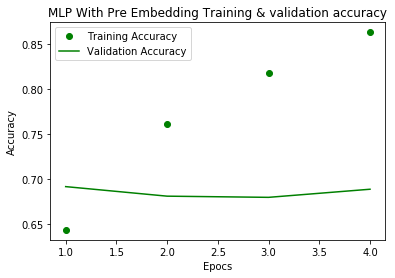

11455/11455 [==============================] - 2s 173us/step


In [17]:
modelName = 'best_mlp_pre_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
mlpNetwork.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
mlpNetworkHistory = mlpNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=mlpNetworkHistory, name="MLP With Pre Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_mlp_pre_embedded_model.csv")

### Build CNN Model with Pre-Embeddings

In [18]:
cnnNetwork = models.Sequential()
cnnNetwork.add(embedding_layer)
cnnNetwork.add(layers.Conv1D(64, 5, activation='relu'))
cnnNetwork.add(layers.MaxPooling1D(4))
cnnNetwork.add(layers.Conv1D(64, 5, activation='relu'))
cnnNetwork.add(layers.MaxPooling1D(4))
cnnNetwork.add(layers.Flatten())
cnnNetwork.add(layers.Dense(64, activation = "relu"))
cnnNetwork.add(layers.Dense(len_categories, activation="softmax"))
cnnNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          3477000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
__________

Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 53s 1ms/step - loss: 0.7911 - acc: 0.7072 - val_loss: 0.6250 - val_acc: 0.7704
Epoch 2/5
38951/38951 [==============================] - 57s 1ms/step - loss: 0.5758 - acc: 0.7899 - val_loss: 0.5714 - val_acc: 0.7891
Epoch 3/5
38951/38951 [==============================] - 52s 1ms/step - loss: 0.5122 - acc: 0.8095 - val_loss: 0.5802 - val_acc: 0.7856
Epoch 4/5
38951/38951 [==============================] - 51s 1ms/step - loss: 0.4603 - acc: 0.8280 - val_loss: 0.5792 - val_acc: 0.7905
Epoch 5/5
38951/38951 [==============================] - 50s 1ms/step - loss: 0.4070 - acc: 0.8470 - val_loss: 0.6209 - val_acc: 0.7811


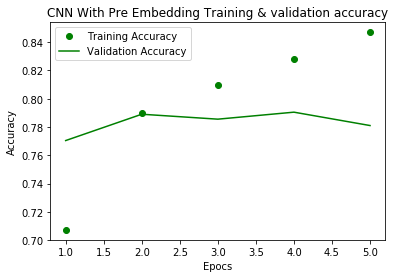

11455/11455 [==============================] - 6s 487us/step


In [19]:
modelName = 'best_cnn_pre_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
cnnNetwork.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnnNetworkHistory = cnnNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=cnnNetworkHistory, name="CNN With Pre Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_cnn_pre_embedded_model.csv")

### Build LSTM Network

In [20]:
lstmNetwork = models.Sequential()
lstmNetwork.add(embedding_layer)
lstmNetwork.add(layers.SpatialDropout1D(0.3))
lstmNetwork.add(layers.LSTM(100))
lstmNetwork.add(layers.Dense(64, activation = "relu"))
lstmNetwork.add(layers.Dropout(0.25))
lstmNetwork.add(layers.Dense(len_categories, activation="softmax"))
lstmNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          3477000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 3,564,254
Trainable params: 87,254
Non-trainable params: 3,477,000
_____________________________________________________________

Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 181s 5ms/step - loss: 1.0343 - acc: 0.6061 - val_loss: 0.7468 - val_acc: 0.7287
Epoch 2/5
38951/38951 [==============================] - 181s 5ms/step - loss: 0.7483 - acc: 0.7272 - val_loss: 0.6444 - val_acc: 0.7649
Epoch 3/5
38951/38951 [==============================] - 207s 5ms/step - loss: 0.6759 - acc: 0.7544 - val_loss: 0.5867 - val_acc: 0.7776
Epoch 4/5
38951/38951 [==============================] - 204s 5ms/step - loss: 0.6267 - acc: 0.7698 - val_loss: 0.5687 - val_acc: 0.7879
Epoch 5/5
38951/38951 [==============================] - 197s 5ms/step - loss: 0.6002 - acc: 0.7790 - val_loss: 0.5446 - val_acc: 0.7943


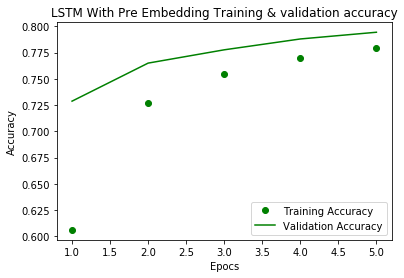

11455/11455 [==============================] - 16s 1ms/step


In [21]:
modelName = 'best_lstm_pre_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
lstmNetwork.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
lstmNetworkHistory = lstmNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=lstmNetworkHistory, name="LSTM With Pre Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_lstm_pre_embedded_model.csv")